## Calculating the evap trans flux for CONUS2.0 runs as this was not output in the original simulations
- This is a necessary input for evaptrans calcs
- Notes on evaptrans calcs from reed [here](https://docs.google.com/document/d/1TNZCPCYj1qsA4OlMlN3NB6XSOuV5fUmY4w4f6O7dm_8/edit?pli=1&tab=t.0):
- This workflow assume you have root zone fractions calculted already refer to `Cacluate_RootZoneFracs.ipynb`
- **right now i'm using the mask to set everything out of the domain to zero, still need to add a fix for lakes and sinks once the rest is working**

Top layer: 
- evap_trans[z] = -qflx_tran_veg * rootfr[z] + qflx_infl + qflx_qirr_inst[z]
  
Remaining Layers: 
 - pf_flux[z]=(-qflx_tran_veg*rootfr[z]) + qflx_qirr_inst[z]

Then scale everything like this: 
- evap_trans(l) = pf_flux[z] * 3.6d0 / dz[z]

Variables: 
- z = vertical layer
- qflx_tran_veg is in the clm outputs (found in *.c.pfb file layer 8 units are [mm/s])
- qflx_infl is in the clm outputs    (found in *.c.pfb file layer 9 units are [mm/s])
- q_irr is the irrigation flux in CONUS2 its zero so I'm ignoring it here

** Note that the fluxes are in [mm/s] units and are converted to [m/h] 3600 [s/h] and 
1000 [mm/m] to be in PF units and then divided by the depth of each soil layer to be in [1/h] units


### Preliminary setup

In [1]:
import pandas as pd
import os 
import numpy as np
import hf_hydrodata as hf
from parflow.tools.io import read_pfb, read_clm, write_pfb
import matplotlib.pyplot as plt
import netCDF4 as nc

email = input('Enter your hydrgen email address')
pin = input('Enter your hydrogen PIN')
print('Registering ' + email + ' (PIN=' + pin + ') for HydroData download' ) 
hf.register_api_pin(email, pin)


Enter your hydrgen email address lecondon@email.arizona.edu
Enter your hydrogen PIN 1234


Registering lecondon@email.arizona.edu (PIN=1234) for HydroData download


In [2]:
#directory with the root fracs and netcdfs for testing
working_dir = "./evap_trans_test" 

#Set this to false if you don't want to regenerate the evaptrans pdfs
# i.e. if you are just doing comparison with the netcdf files for testing
run_calcs = True

#DZ list for CONUS2
dz_list = [0.1, 0.3, 0.6, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0, 200.0]

#number of layers the root zone is distributed over in PF-CLM coupling
nroot_lay = 4 

#hour start and end for runn
hstart = 1
hend = 24

#Water year for the CONUS simultions
wy= 2003

#CONUS2 dimensions
nz=10
ny=3256
nx=4442

# read in the root zone fractions
top_depth = np.append(0, np.cumsum(dz_list)) #Top depth of each layer
root_fracs=np.zeros((nroot_lay, ny, nx))
for layer in range(nroot_lay):
    fin=os.path.join(working_dir, f'root_zone_frac_layer{layer}_{top_depth[layer]}-{top_depth[layer+1]}.pfb')
    root_fracs[layer,:,:] = read_pfb(fin)
    print(np.mean(root_fracs[layer,:,:]))

# plot one layer just to check it looks okay
#str= plt.imshow(root_fracs[3,:,:], cmap = "RdBu", origin='lower')
#str.set_clim(vmin=0, vmax=0.25)
#plt.colorbar(str, ax=plt.gca())
#plt.show()

0.15637811339595195
0.21775012080822953
0.11759394621703805
0.03981820180463524


In [3]:
# Read in the mask file
options = {
      "dataset":"conus2_domain", "variable": "mask"}
mask = hf.get_gridded_data(options)
print(mask.shape)
print(np.sum(mask))

#Read in the top patch file
options = {
      "dataset":"conus2_domain", "variable": "top_patch"}
top_patch = hf.get_gridded_data(options)
print(top_patch.shape)

(3256, 4442)
7852823.0
(3256, 4442)


### Calculate the evap trans and write out as pfb


In [18]:
ltran = 8  #Layer of tran_veg in the clm_file
linfl = 9 #Layer of qflux_infl in the clm file

# Use these three lines if you just want to run a single 
# hour for testing. If not comment them out
htest=1
hstart = htest
hend = htest


if run_calcs:
    print("Calculating Evap Trans from", hstart, "to", hend)
    for wy_hour in range(hstart, (hend+1)):
        print(wy_hour)

        #make an empty array for the evaptrans
        evap_trans = np.zeros((nz, ny, nx))

        #Read in the clm outputs
        fin1 = f"/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/run_inputs/spinup.wy{wy}.out.clm_output.{wy_hour:05d}.C.pfb"
        tran_veg = read_pfb(fin1, keys={'z': {'start': ltran, 'stop': (ltran+1),}})[0,::]
        infl = read_pfb(fin1, keys={'z': {'start': linfl, 'stop': (linfl+1),}})[0,:,:]
        print("total transpiration:", np.sum(tran_veg[mask==1]))
        print("total infiltration:", np.sum(infl[mask==1]))
        
        # Calculate the evaptrans in the first layer
        # evap_trans[z] = qflx_tran_veg * rootfr[z] + qflx_infl + qflx_qirr_inst[z]
        # *3.6 because 1 mm/s = 3.6 m/hr
        # /dz to get to units of 1/hr
        evap_trans[0,:,:] = (-tran_veg * root_fracs[0,:,:] + infl) * mask * 3.6 /dz_list[0] # Assuming qirr=0

        #Calculate evaptrans in remaining clm layers
        # pf_flux[z]=(-qflx_tran_veg*rootfr[z]) + qflx_qirr_inst[z]
        for l in range(1,nroot_lay):
            evap_trans[l, :, :] = (- tran_veg * root_fracs[l,:,:]) * mask * 3.6 /dz_list[l] # Assuming qirr=0
        
        #Write it out as a pfb
        fout = os.path.join(working_dir, f'calculated_evaptrans.{wy_hour:05d}.pfb')
        write_pfb(fout, evap_trans, dist=False)
    
    print(tran_veg.shape)
    print(np.sum(tran_veg[mask==1]), np.sum(infl[mask==1]))
else:
    print("Not recalculating the EvapTrans files")

Calculating Evap Trans from 1 to 1
1
total transpiration: 25.848449855488116
total infiltration: 61.64276455221861
(3256, 4442)
25.848449855488116 61.64276455221861


## Check the evaptrans calculations
Looks like the issue is that the trans and infil numbers I have in the pfb outputs do not match George's net cdf. 

Transpiration numbers are close but the infiltration numbers are about twice as large in the netcdf files as in the pfb

I also checked below printing out the sum for all layers that the currect values where just at a different index value that I missed. 

And I checed that they aren't one time step off. 

It looks like I am grabbing the right layers and the right timesteps the values are just off between the pfbs and the netcdf

In [27]:
#Check that the transpiration and infiltration numbers match
fin= os.path.join(working_dir, '24h_test.out.CLM.00001.nc')
clm_output = nc.Dataset(fin)
#print(clm_output.variables)

qtrans = clm_output.variables['qflx_tran_veg']
qinf = clm_output.variables['qflx_infl']

print(qtrans.shape)
print(qinf.shape)

print("total transpiration:", np.sum(qtrans[(htest-1),:,:][mask==1]))
print("total infiltration:", np.sum(qinf[(htest-1),:,:][mask==1]))

# Read the C.pfb and see if I have any numbers that match
wy_hour = htest
fin1 = f"/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/run_inputs/spinup.wy{wy}.out.clm_output.{wy_hour:05d}.C.pfb"
testP = read_pfb(fin1)
print(testP.shape)
for i in range(17):
    print(i)
    print(np.sum(testP[i,:,:][mask==1]))
          

(24, 3256, 4442)
(24, 3256, 4442)
total transpiration: 7.817570429946318
total infiltration: 110.49314703308312
(17, 3256, 4442)
0
212312336.90807196
1
3089798736.9760814
2
-197977943.69047487
3
-529170539.7884618
4
84.57309707806597
5
62.28064841008338
6
62.282495025387504
7
22.290602052678548
8
7.420300444349982
9
78.82129643428397
10
11484.75266307308
11
2325116281.5816584
12
0.0
13
2355846834.347573
14
2355824632.7893896
15
2353857098.452109
16
2325138342.3868895


{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
unlimited dimensions: time
current shape = (24,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'pressure': <class 'netCDF4._netCDF4.Variable'>
float64 pressure(time, z, y, x)
unlimited dimensions: time
current shape = (24, 10, 3256, 4442)
filling on, default _FillValue of 9.969209968386869e+36 used, 'saturation': <class 'netCDF4._netCDF4.Variable'>
float64 saturation(time, z, y, x)
unlimited dimensions: time
current shape = (24, 10, 3256, 4442)
filling on, default _FillValue of 9.969209968386869e+36 used, 'evaptrans': <class 'netCDF4._netCDF4.Variable'>
float64 evaptrans(time, z, y, x)
unlimited dimensions: time
current shape = (24, 10, 3256, 4442)
filling on, default _FillValue of 9.969209968386869e+36 used}
(24, 10, 3256, 4442)
(10, 3256, 4442)
-3.570970703190867e-06
-1.7056546513380145e-05


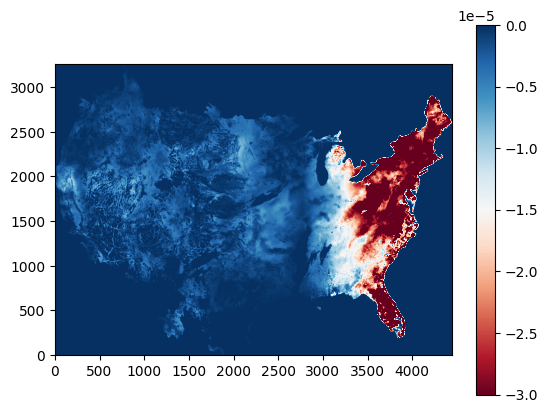

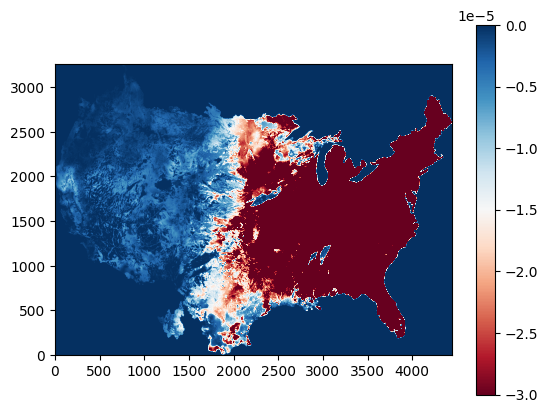

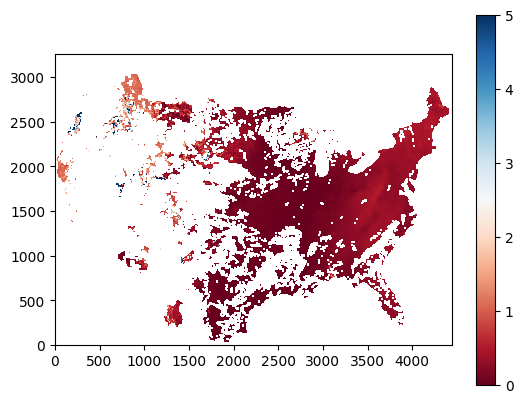

In [56]:
# Read in the PF nc file outputs
fin= os.path.join(working_dir, '24h_test.out.00001.nc')
pf_output = nc.Dataset(fin)
print(pf_output.variables)
pf_evaptrans = pf_output.variables['evaptrans']
print(pf_evaptrans.shape)

#Read in the calculated evap trans for one test hour
h_test = 13
fin = os.path.join(working_dir, f'calculated_evaptrans.{h_test:05d}.pfb')
test_evaptrans = read_pfb(fin)
print(test_evaptrans.shape)


l_test = 1 # Layer from the top moving down starting couting at 0
slice_testC = test_evaptrans[l_test,:,:]
slice_testP = pf_evaptrans[h_test,(9-l_test),:,:]
print(np.mean(slice_testC))
print(np.mean(slice_testP)) 

#Test if I'm off by a constant factor
#print(np.mean(slice_testC/slice_test))
#print(np.mean(slice_testP)) 

str= plt.imshow(slice_testC, cmap = "RdBu", origin='lower')
str.set_clim(vmin=(-3*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.show()

str= plt.imshow(slice_testP, cmap = "RdBu", origin='lower')
str.set_clim(vmin=(-3*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.show()

str= plt.imshow(slice_testC/slice_testP, cmap = "RdBu", origin='lower')
str.set_clim(vmin=0, vmax=5)
plt.colorbar(str, ax=plt.gca())
plt.show()